Train a GPR model with "RDkit featurization" and check performance by r2_score, MSE, MAE

In [15]:
# Train a GPR model with RDkit featurization
import deepchem as dc
import pandas as pd
import numpy as np
import optuna
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern

In [4]:
#load the dataset (polymer smiles and their energy of atomization)

print("loading the data...")
loader = dc.data.CSVLoader(["Eat"], feature_field="smiles", featurizer=dc.feat.RDKitDescriptors())
Data = loader.create_dataset('../csv_files/Polymers_Eat.csv')

loading the data...


In [5]:
print("before:  ",Data)
#some RDKit descriptors return nan, make these 0
X = np.nan_to_num(Data.X, copy=True, nan=0.0)
#add data to dataset
Dataset = dc.data.DiskDataset.from_numpy(X=X, y=Data.y, w=Data.w, ids=Data.ids, tasks = ["Eat"])
print("after:  ",Dataset)

before:   <DiskDataset X.shape: (390, 210), y.shape: (390, 1), w.shape: (390, 1), ids: ['[*]CC([*])C' '[*]CC([*])F' '[*]CC([*])(F)F' ...
 '[*]C(F)(F)C(=O)C(F)(F)C(C=C1)=CC=C1[*]' '[*]C(F)(F)OC(F)(F)O[*]'
 '[*]N(C(=O)C1=C2)C(=O)C1=CC=C2C(=O)C(=CC=C3C4(=O))C=C3C(=O)N4C(C)COCCOCCOC(C)COCC(C)[*]'], task_names: ['Eat']>
after:   <DiskDataset X.shape: (390, 210), y.shape: (390, 1), w.shape: (390, 1), ids: ['[*]CC([*])C' '[*]CC([*])F' '[*]CC([*])(F)F' ...
 '[*]C(F)(F)C(=O)C(F)(F)C(C=C1)=CC=C1[*]' '[*]C(F)(F)OC(F)(F)O[*]'
 '[*]N(C(=O)C1=C2)C(=O)C1=CC=C2C(=O)C(=CC=C3C4(=O))C=C3C(=O)N4C(C)COCCOCCOC(C)COCC(C)[*]'], task_names: ['Eat']>


In [6]:
#split the dataset using the random splitter
splitter = dc.splits.RandomSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(Dataset)
print("Data is splitted into: train, valid, test")

Data is splitted into: train, valid, test


In [16]:
## finetuning parameters
def get_model(trial):
    output_variance = trial.suggest_float('output_variance', 0.1, 10, log=True)
    length_scale = trial.suggest_float('length_scale', 1e-5, 1e5, log=True)
    noise_level = trial.suggest_float('noise_level', 1e-5, 1e5, log=True)

    params = {
        'kernel': output_variance**2 * Matern(length_scale=length_scale, length_scale_bounds='fixed') + WhiteKernel(noise_level=noise_level, noise_level_bounds='fixed'),
        'alpha': trial.suggest_float('alpha', 1e-12, 1e-5, log=True),
    }

    sklearn_gpr = GaussianProcessRegressor(**params)
    return dc.models.SklearnModel(sklearn_gpr)

def objective(trial):
    model = get_model(trial)
    model.fit(train_dataset)
    
    metric = dc.metrics.Metric(dc.metrics.mean_squared_error)
    return model.evaluate(valid_dataset, [metric])['mean_squared_error']

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)


[I 2024-03-01 09:40:06,651] A new study created in memory with name: no-name-4dcf0a27-1c2c-4ed3-8f34-c759e51714e7
[I 2024-03-01 09:40:06,814] Trial 0 finished with value: 7.639053180268849 and parameters: {'output_variance': 0.1593778997340992, 'length_scale': 17.716913297989407, 'noise_level': 3.089288320053265, 'alpha': 2.5597215292276654e-07}. Best is trial 0 with value: 7.639053180268849.
c:\Users\wanne\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
[I 2024-03-01 09:40:07,199] Trial 1 finished with value: 0.0023369507182937465 and parameters: {'output_variance': 1.1333192420607736, 'length_scale': 1800.8005868205532, 'noise_level': 1.5125222774705679e-05, 'alpha': 3.

In [17]:
# create the GPR model & fit the model
output_variance = study.best_params['output_variance']
length_scale = study.best_params['length_scale']
noise_level = study.best_params['noise_level']
kernel = output_variance**2 * Matern(length_scale=length_scale, length_scale_bounds='fixed') + WhiteKernel(noise_level=noise_level, noise_level_bounds='fixed')
alpha = study.best_params['alpha']

kernel = 1 * RBF()
model = dc.models.SklearnModel(GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=200))

print("fitting model...")
model.fit(train_dataset)
print("model is fitted")

fitting model...
model is fitted


In [18]:
#calculate r2 score
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
print('Training set score:', model.evaluate(train_dataset, metric))
test_score= model.evaluate(test_dataset, metric)
print('Test set score:',test_score )

Training set score: {'pearson_r2_score': 0.9999999999999993}
Test set score: {'pearson_r2_score': 0.93009152982127}


In [19]:
#calculate MSE score
metric = dc.metrics.Metric(dc.metrics.mean_squared_error)
print('Training set score:', model.evaluate(train_dataset, metric))
print('Test set score:', model.evaluate(test_dataset, metric))

Training set score: {'mean_squared_error': 5.1829663354517504e-17}
Test set score: {'mean_squared_error': 0.010856701736243198}


In [28]:
#predict the r2_score and convert to string
predicted = model.predict(test_dataset)

#convert tekst to string, so it can be depicted in matplotlib
number=list(test_score.values())[0]
text = "r2= "+ str(round(number,3))

real = test_dataset.y
#remove extreme outliers:
print(predicted.shape)
for idx, value in enumerate(predicted):
    if value >5:
        print("outlier removed")
        predicted=np.delete(predicted,idx)
        real=np.delete(test_dataset.y,idx)
print(predicted.shape)

score =r2_score(real, predicted)
text = "r2= "+ str(round(score,3))

(39,)
(39,)


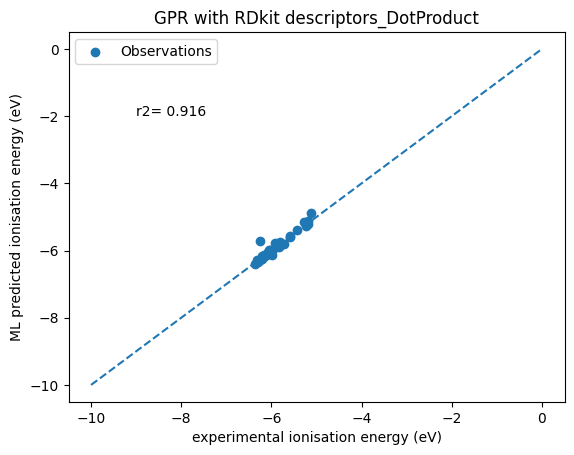

In [29]:
#plot the data
import matplotlib.pyplot as plt

x=[-10,0]
y=[-10,0]
plt.plot(x, y, linestyle="dashed")
plt.scatter(real, predicted, label="Observations")
plt.legend()
plt.xlabel("experimental ionisation energy (eV)")
plt.ylabel("ML predicted ionisation energy (eV)")
plt.title("GPR with RDkit descriptors_DotProduct")
plt.text(-9,-2,text)
plt.show()
